# Introduction to DESI Spectra

The goal of this notebook is to demonstrate how to read in and manipulate DESI spectra using simulated spectra created as part of a DESI Data Challenge.

If you identify any errors or have requests for additional functionality please create a new issue on https://github.com/desihub/tutorials/issues or send a note to desi-data@desi.lbl.gov.

Last updated November 2017 using desi software release 17.9.

## Getting started

### Using NERSC

The easiest way to get started is to use the jupyter server at NERSC so that you don't need to
install any code or download any data locally.

If you need a NERSC account, see https://desi.lbl.gov/trac/wiki/Computing/AccessNersc

Then do the one-time jupyter-dev configuration described at https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC

From a NERSC command line, checkout a copy of the tutorial code, e.g. from cori.nersc.gov
```console
mkdir -p $HOME/desi/
cd $HOME/desi/
git clone https://github.com/desihub/tutorials
```
And then go to https://jupyter-dev.nersc.gov, login, navigate to where you checked out this package (e.g. `$HOME/desi/tutorials`), and double-click on `Intro_to_DESI_spectra.ipynb`.

This tutorial has been tested using the "desi 17.9" kernel installed at NERSC.  To get an equivalent environment from a cori command line:
```
source /project/projectdirs/desi/software/desi_environment.sh 17.9
```

### Using your own laptop

Install the desi code packages following instructions at https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop .  See the end of this tutorial for the exact package versions used.

Get a copy of some data from NERSC, e.g. the tarball at `/project/projectdirs/desi/datachallenge/dc17a-twopct/dc17a-lite.tar.gz`, but note that even that very minimal sample is 7.3 GB.

## Import required modules

In [1]:
import os
import numpy as np
import healpy as hp
from glob import glob
import fitsio
from collections import defaultdict

from desitarget import desi_mask
import desispec.io

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


If you are running locally and any of these fail, 
you should go back through the [installation instructions]( https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) and/or email desi-data@desi.lbl.gov if you get stuck.
If you are running from jupyter-dev and have problems, double check that your kernel is "desi 17.9".

## Environment variables and data

Like BOSS, DESI uses environment variables to define the base directories for where to find data.  The below paths are for NERSC, but if you are running locally or want to access a different dataset, change these as needed to wherever your dataset is.

Spectro production runs are grouped under `$DESI_SPECTRO_REDUX`, with `$SPECPROD` indicating which run to use, such that the data are under `$DESI_SPECTRO_REDUX/$SPECPROD`.  e.g. during operations, official productions will be in `$DESI_SPECTRO_REDUX=/project/projectdirs/desi/spectro/redux` and `$SPECPROD` would be the name for individual data assemblies, e.g. `$SPECPROD=DA1`.  In this case, we'll use the "dc17b" data challenge data.

In [2]:
%set_env DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/
%set_env SPECPROD=dc17b

env: DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/
env: SPECPROD=dc17b


`desispec.io.specprod_root` can handle the environment variable path wrangling for you:

In [3]:
reduxdir = desispec.io.specprod_root()
print(reduxdir)

/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b


In [4]:
#- Do check that these are set correctly before proceeding
def check_env():
    for env in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
        if env in os.environ:
            print('${}={}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

    reduxdir = desispec.io.specprod_root()
    if not os.path.exists(reduxdir):
        print("ERROR: {} doesn't exist; check $DESI_SPECTRO_REDUX/$SPECPROD".format(reduxdir))
    else:
        print('OK: {} exists'.format(reduxdir))

check_env()

$DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/
$SPECPROD=dc17b
OK: /project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b exists


## Data Model for the spectra

### Directory structure

Spectra from individual exposures are in the `exposures` directory.  But since DESI will take multiple exposures of overlapping tiles, the data from any given target or patch of sky could be spread across multiple files in multiple directories.  To simplify this, the calibrated spectra are repackaged into a `spectra-64` directory, where all spectra for a given healpix on the sky are grouped together.  See an appendix to this tutorial for a quick overview of healpix.

The directory structure is: 

```
$DESI_SPECTRO_REDUX/$SPECPROD/spectra-{nside}/{group}/{pix}/*-{nside}-{pix}.fits`
```

where
  * `nside` is the healpix nside hierarchy level with a default is
    nside=64 corresponding to pixels of 0.84 $deg^2$ with a few thousand targets each.
  * `group = nside//100` to avoid having thousands of directories at the same level
  * `pix` is the healpixel number using the *nested* scheme.

For example for `nside=64` and `pixel=16879`:

```
$DESI_SPECTRO_REDUX/$SPECTRO/spectra-64/168/16879/spectra-64-16879.fits
$DESI_SPECTRO_REDUX/$SPECTRO/spectra-64/168/16879/zbest-64-16879.fits
```

where the first file contains the spectra and the second file contains information on the best-fit redshifts from the [redrock](https://github.com/desihub/redrock) code.

Let's poke around in these directories.

In [5]:
basedir = os.path.join(os.getenv("DESI_SPECTRO_REDUX"),os.getenv("SPECPROD"),"spectra-64")
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b/spectra-64
['69', '368', '80', '119', '199', '53', '187', '7', '133', '56', '51', '125', '21', '121', '59', '276', '226', '75', '70', '78', '43', '6', '108', '46', '188', '41', '134', '49', '176', '126', '122', '160', '110', '227', '223', '194', '190', '60', '68', '366', '203', '63', '283', '5', '300', '109', '189', '135', '177', '127', '123', '55', '278', '50', '111', '153', '224', '58', '195', '191', '23', '183', '1', '367', '204', '26', '74', '284', '280', '230', '77', '45', '178', '124', '48', '112', '196', '0', '192', '184', '255', '180', '201', '67', '285', '281', '62', '231', '362', '179', '159', '54', '197', '193', '57', '185', '181', '52', '22', '202', '286', '282', '25', '232', '20', '9', '76', '71', '363', '79', '44', '118', '47', '198', '42', '186', '182', '174', '120', '279', '66', '275', '61', '225']


In [6]:
basedir = os.path.join(basedir,subdir[0])
subdir = os.listdir(basedir)
pixnums = np.array([int(pixnum) for pixnum in subdir])
print(basedir)
print(subdir)

/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b/spectra-64/69
['6972', '6947', '6973', '6948', '6920', '6957', '6958', '6944', '6959', '6945', '6953', '6968', '6954', '6955', '6901', '6956', '6950', '6951', '6926', '6952', '6974', '6975', '6921', '6962', '6922', '6923', '6970', '6971', '6946']


In [7]:
basedir = os.path.join(basedir,subdir[0])
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b/spectra-64/69/6972
['zbest-64-6972.fits', 'rr-64-6972.log', 'rr-64-6972.h5', 'spectra-64-6972.fits']


`desispec.io.findfile` provides utility functions for the path wrangling, e.g.

In [8]:
desispec.io.findfile('spectra', groupname=6972)

'/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b/spectra-64/69/6972/spectra-64-6972.fits'

### spectra file format

What about the Data Model for the spectra themselves?

In [9]:
specfiles = sorted(glob(reduxdir+'/spectra-64/*/*/spectra*.fits'))
specfilename = specfiles[0]
DM = fitsio.FITS(specfilename)
DM


  file: /project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b/spectra-64/0/0/spectra-64-0.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      IMAGE_HDU       B_WAVELENGTH
  3      IMAGE_HDU       B_FLUX
  4      IMAGE_HDU       B_IVAR
  5      IMAGE_HDU       B_MASK
  6      IMAGE_HDU       B_RESOLUTION
  7      IMAGE_HDU       R_WAVELENGTH
  8      IMAGE_HDU       R_FLUX
  9      IMAGE_HDU       R_IVAR
  10     IMAGE_HDU       R_MASK
  11     IMAGE_HDU       R_RESOLUTION
  12     IMAGE_HDU       Z_WAVELENGTH
  13     IMAGE_HDU       Z_FLUX
  14     IMAGE_HDU       Z_IVAR
  15     IMAGE_HDU       Z_MASK
  16     IMAGE_HDU       Z_RESOLUTION

HDU 0 is blank.  The others should be used by name, not by number since the order could vary.

`FIBERMAP` stores the mapping of the imaging information used to target and place a fiber on the source.

The other HDUs contain the wavelength arrays, flux, inverse variance (ivar), mask (0 is good), and spectral resolution data for each of the "B", "R", and "Z" cameras.

Let's start by looking at the fibermap.

In [10]:
fm = fitsio.read(specfilename,'FIBERMAP')
fm.dtype.descr

[('OBJTYPE', '|S10'),
 ('TARGETCAT', '|S20'),
 ('BRICKNAME', '|S8'),
 ('TARGETID', '>i8'),
 ('DESI_TARGET', '>i8'),
 ('BGS_TARGET', '>i8'),
 ('MWS_TARGET', '>i8'),
 ('MAG', '>f4', (5,)),
 ('FILTER', '|S10', (5,)),
 ('SPECTROID', '>i4'),
 ('POSITIONER', '>i4'),
 ('LOCATION', '>i4'),
 ('DEVICE_LOC', '>i4'),
 ('PETAL_LOC', '>i4'),
 ('FIBER', '>i4'),
 ('LAMBDAREF', '>f4'),
 ('RA_TARGET', '>f8'),
 ('DEC_TARGET', '>f8'),
 ('RA_OBS', '>f8'),
 ('DEC_OBS', '>f8'),
 ('X_TARGET', '>f8'),
 ('Y_TARGET', '>f8'),
 ('X_FVCOBS', '>f8'),
 ('Y_FVCOBS', '>f8'),
 ('Y_FVCERR', '>f4'),
 ('X_FVCERR', '>f4'),
 ('NIGHT', '>i4'),
 ('EXPID', '>i4')]

`TARGETID` is the unique mapping from target information to a fiber. So, if you wanted to look up full imaging information for a spectrum, you can map back to target files using `TARGETID`.

Just out of interest, are the RAs and Decs of these objects in the expected HEALPix pixel?

In [11]:
pixnums = hp.ang2pix(64, fm["RA_TARGET"], fm["DEC_TARGET"], nest=True, lonlat=True)
print(np.min(pixnums),np.max(pixnums))
print(specfilename)

0 0
/project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b/spectra-64/0/0/spectra-64-0.fits


I wonder what (roughly) the entirety of this pixel looks like, as mapped out by sources with spectra:

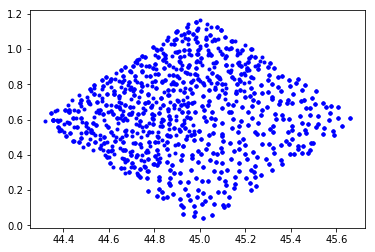

In [12]:
plt.plot(fm["RA_TARGET"],fm["DEC_TARGET"],'b.')

If you are running this at NERSC on dc17b, that first spectra file will be for healpixel 0, i.e. spectra-64-0.fits.  You can see a different density in different parts of the tiles, due to different overlapping exposures.  Let's repeat, color coding by exposure number.

expid 512 includes 508 targets
expid 513 includes 508 targets
expid 514 includes 508 targets
expid 300 includes 292 targets
expid 25 includes 1 targets
expid 26 includes 1 targets
expid 27 includes 1 targets


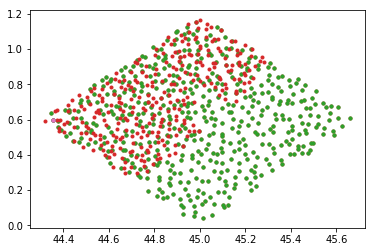

In [13]:
for expid in set(fm['EXPID']):
    ii = (fm['EXPID'] == expid)
    print('expid {} includes {} targets'.format(expid, np.count_nonzero(ii)))
    plot(fm['RA_TARGET'][ii], fm['DEC_TARGET'][ii], '.')

Why do we have 7 exposures but only 2 colors (3 colors if you look really carefully...)?
This version of the code neglected to propagate the TILEID into the spectra file so it isn't completely obvious, but what's happening here is that we have multiple exposures of the same targets on the same tile and all those points overlap.

In [14]:
DM


  file: /project/projectdirs/desi/datachallenge/dc17b/spectro/redux/dc17b/spectra-64/0/0/spectra-64-0.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      IMAGE_HDU       B_WAVELENGTH
  3      IMAGE_HDU       B_FLUX
  4      IMAGE_HDU       B_IVAR
  5      IMAGE_HDU       B_MASK
  6      IMAGE_HDU       B_RESOLUTION
  7      IMAGE_HDU       R_WAVELENGTH
  8      IMAGE_HDU       R_FLUX
  9      IMAGE_HDU       R_IVAR
  10     IMAGE_HDU       R_MASK
  11     IMAGE_HDU       R_RESOLUTION
  12     IMAGE_HDU       Z_WAVELENGTH
  13     IMAGE_HDU       Z_FLUX
  14     IMAGE_HDU       Z_IVAR
  15     IMAGE_HDU       Z_MASK
  16     IMAGE_HDU       Z_RESOLUTION

The remaining extensions store the wavelength, flux, inverse variance on the flux, mask and resolution matrix for the B, R and Z arms of the spectrograph. Let's determine the wavelength coverage of each spectrograph:

In [15]:
bwave = fitsio.read(specfilename, 'B_WAVELENGTH')
rwave = fitsio.read(specfilename, 'R_WAVELENGTH')
zwave = fitsio.read(specfilename, 'Z_WAVELENGTH')
print("B coverage: {:.1f} to {:.1f} Angstroms".format(np.min(bwave),np.max(bwave)))
print("R coverage: {:.1f} to {:.1f} Angstroms".format(np.min(rwave),np.max(rwave)))
print("Z coverage: {:.1f} to {:.1f} Angstroms".format(np.min(zwave),np.max(zwave)))

B coverage: 3569.4 to 5948.4 Angstroms
R coverage: 5625.4 to 7740.4 Angstroms
Z coverage: 7435.4 to 9833.4 Angstroms


## Reading in and Displaying spectra

Now that we understand the Data Model, let's plot some spectra. To start, let's use the file we've already been manipulating and read in the flux to go with the wavelengths we already have.

In [16]:
bflux = fitsio.read(specfilename,'B_FLUX')
rflux = fitsio.read(specfilename,'R_FLUX')
zflux = fitsio.read(specfilename,'Z_FLUX')

Note that the wavelength arrays are 1-D (every spectrum in the spectral file is mapped to the same binning in wavelength) but the flux array (and flux_ivar, mask etc. arrays) are 2-D, because they contain multiple spectra:

In [17]:
print(bwave.shape)
print(bflux.shape)

(2380,)
(1819, 2380)


Let's plot the zeroth spectrum in this file (i.e. in this HEALPix grouping):

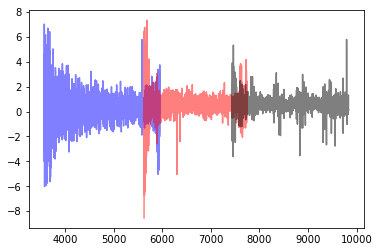

In [18]:
spectrum = 0
plt.plot(bwave,bflux[spectrum], 'b', alpha=0.5)
plt.plot(rwave,rflux[spectrum], 'r', alpha=0.5)
plt.plot(zwave,zflux[spectrum], 'k', alpha=0.5)

## A DESI-specific spectrum reader

Note that, for illustrative purposes, we discussed the Data Model in detail and read in the required files individually from that Data Model. But, the DESI data team has also developed standalone functions in `desispec.io` to facilitate reading in the plethora of information in the spectral files. For example:

In [19]:
specobj = desispec.io.read_spectra(specfilename)

The wavelengths and flux in each band are then available as dictionaries in the `wave` and `flux` attributes:

In [20]:
specobj.wave

{'b': array([ 3569.39990234,  3570.39990234,  3571.39990234, ...,  5946.39990234,
         5947.39990234,  5948.39990234]),
 'r': array([ 5625.39990234,  5626.39990234,  5627.39990234, ...,  7738.39990234,
         7739.39990234,  7740.39990234]),
 'z': array([ 7435.39990234,  7436.39990234,  7437.39990234, ...,  9831.40039062,
         9832.40039062,  9833.40039062])}

In [21]:
specobj.flux

{'b': array([[ 4.63073683, -1.37243927, -3.08227134, ..., -0.03293409,
          3.75174117,  1.23317623],
        [-0.93812722,  0.62578022,  0.43605497, ...,  0.24565338,
         -5.643291  ,  3.50443482],
        [ 1.49709976,  0.8637414 , -5.88399124, ...,  0.4675619 ,
          5.82154369,  7.16638374],
        ..., 
        [-0.19783381,  3.61727691, -6.68722582, ..., -1.14848304,
          6.87145948,  0.53778613],
        [ 3.6490798 ,  4.06604624,  0.81131637, ...,  0.1389135 ,
         -1.70421505,  0.72155344],
        [ 1.29488742, -0.43144009,  1.93299282, ...,  1.25562286,
          4.04907894, -2.86905432]]),
 'r': array([[ -8.54925251,   6.02174187,  -1.76119971, ...,   2.17052197,
          -0.15920688,   2.28578568],
        [  1.06694937,   2.35472274,   2.46112156, ...,  -0.10548622,
          -1.2577703 ,   0.94947743],
        [  3.68596625,   3.77367306,  10.26689816, ...,   5.43154526,
           3.99145389,   3.01226711],
        ..., 
        [  2.07588434,  

So, to plot the "zeroth" spectrum:

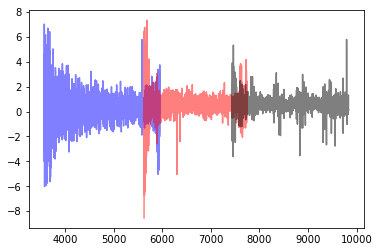

In [22]:
spectrum = 0
plt.plot(specobj.wave["b"],specobj.flux["b"][spectrum],color='b', alpha=0.5)
plt.plot(specobj.wave["r"],specobj.flux["r"][spectrum],color='r', alpha=0.5)
plt.plot(specobj.wave["z"],specobj.flux["z"][spectrum],color='k', alpha=0.5)

which should look very similar to one of the first plots we made earlier in the tutorial. 

The fibermap information is available as a table in the `fibermap` attribute:

In [23]:
specobj.fibermap

OBJTYPE,TARGETCAT,BRICKNAME,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,MAG [5],FILTER [5],SPECTROID,POSITIONER,LOCATION,DEVICE_LOC,PETAL_LOC,FIBER,LAMBDAREF,RA_TARGET,DEC_TARGET,RA_OBS,DEC_OBS,X_TARGET,Y_TARGET,X_FVCOBS,Y_FVCOBS,Y_FVCERR,X_FVCERR,NIGHT,EXPID
bytes10,bytes20,bytes8,int64,int64,int64,int64,float32,bytes10,int32,int32,int32,int32,int32,int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,int32
SCIENCE,,0448p005,288230376151712283,1152921504606846976,65537,0,21.5131 .. 18.7715,DECAM_G .. WISE_W2,6,6490,6490,490,6,3001,5400.0,44.7702026367,0.414087384939,44.7702026367,0.414087384939,-232.460983276,304.582641602,-232.460983276,304.582641602,0.0,0.0,20191215,300
SCIENCE,,0446p002,288230376151711819,1152921504606846976,131074,0,19.7552 .. 19.3677,DECAM_G .. WISE_W2,6,6503,6503,503,6,3008,5400.0,44.7254142761,0.298312246799,44.7254142761,0.298312246799,-221.937561035,335.018035889,-221.937561035,335.018035889,0.0,0.0,20191215,300
SCIENCE,,0448p005,288230376151716054,3458764513820540928,65537,65536,20.7188 .. 19.5856,DECAM_G .. WISE_W2,6,6522,6522,522,6,3011,5400.0,44.8901237787,0.412607930779,44.8901237787,0.412607930779,-263.803771973,306.161987305,-263.803771973,306.161987305,0.0,0.0,20191215,300
SCIENCE,,0448p002,288230376151712147,1152921504606846976,131074,0,20.341 .. 18.9984,DECAM_G .. WISE_W2,6,6505,6505,505,6,3012,5400.0,44.755657196,0.364803731441,44.755657196,0.364803731441,-229.151596069,317.535888672,-229.151596069,317.535888672,0.0,0.0,20191215,300
SCIENCE,,0446p002,288230376151711820,1152921504606846976,65537,0,20.6446 .. 19.1919,DECAM_G .. WISE_W2,6,6488,6488,488,6,3014,5400.0,44.7394981384,0.368101149797,44.7394981384,0.368101149797,-224.922821045,316.50592041,-224.922821045,316.50592041,0.0,0.0,20191215,300
SCIENCE,,0446p002,288230376151711838,1152921504606846976,131074,0,18.4124 .. 17.4619,DECAM_G .. WISE_W2,6,6447,6447,447,6,3015,5400.0,44.6204605103,0.32858273387,44.6204605103,0.32858273387,-194.508712769,325.978881836,-194.508712769,325.978881836,0.0,0.0,20191215,300
SCIENCE,,0448p005,288230376151712226,1152921504606846976,131074,0,21.1737 .. 18.0984,DECAM_G .. WISE_W2,6,6507,6507,507,6,3016,5400.0,44.815284729,0.406641840935,44.815284729,0.406641840935,-244.269775391,306.987060547,-244.269775391,306.987060547,0.0,0.0,20191215,300
SCIENCE,,0448p005,288230376151712300,1152921504606846976,131074,0,20.3239 .. 17.5242,DECAM_G .. WISE_W2,6,6508,6508,508,6,3018,5400.0,44.8432235718,0.456257671118,44.8432235718,0.456257671118,-251.071380615,294.118164062,-251.071380615,294.118164062,0.0,0.0,20191215,300
SKY,,0446p005,864691128455140707,4294967296,0,0,inf .. inf,DECAM_G .. WISE_W2,6,6489,6489,489,6,3020,5400.0,44.7457618713,0.397235274315,44.7457618713,0.397235274315,-226.274734497,308.824127197,-226.274734497,308.824127197,0.0,0.0,20191215,300


Since there can be multiple spectra for a single `TARGETID` (from multiple cameras and/or multiple exposures), there is a utility function for getting the `TARGETID`s in this file:

In [24]:
specobj.target_ids()

288230376151712283
288230376151711819
288230376151716054
288230376151712147
288230376151711820
288230376151711838
288230376151712226
288230376151712300
864691128455140707
288230376151711866
288230376151711907


There are also functions for getting the number of spectra and selecting a subset of spectra.  All of the information that could be read in from the different extensions of the spectral file can be retrieved from the `specobj` object. Here's what's available:

In [25]:
dir(specobj)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bands',
 '_ftype',
 '_single',
 'bands',
 'extra',
 'fibermap',
 'flux',
 'ftype',
 'ivar',
 'mask',
 'meta',
 'num_spectra',
 'num_targets',
 'resolution_data',
 'select',
 'target_ids',
 'update',
 'wave',
 'wavelength_grid']

## Target classes

What about if we only want to plot spectra of certain target classes? The targeting information is stored in the `DESI_TARGET`, `BGS_TARGET` and `MWS_TARGET` entries of the fibermap array:

In [26]:
specobj.fibermap.info

<Table length=1819>
    name     dtype  shape n_bad
----------- ------- ----- -----
    OBJTYPE bytes10           0
  TARGETCAT bytes20           0
  BRICKNAME  bytes8           0
   TARGETID   int64           0
DESI_TARGET   int64           0
 BGS_TARGET   int64           0
 MWS_TARGET   int64           0
        MAG float32  (5,)   623
     FILTER bytes10  (5,)     0
  SPECTROID   int32           0
 POSITIONER   int32           0
   LOCATION   int32           0
 DEVICE_LOC   int32           0
  PETAL_LOC   int32           0
      FIBER   int32           0
  LAMBDAREF float32           0
  RA_TARGET float64           0
 DEC_TARGET float64           0
     RA_OBS float64           0
    DEC_OBS float64           0
   X_TARGET float64           0
   Y_TARGET float64           0
   X_FVCOBS float64           0
   Y_FVCOBS float64           0
   Y_FVCERR float32           0
   X_FVCERR float32           0
      NIGHT   int32           0
      EXPID   int32           0

and which target corresponds to which targeting bit is stored in the desitarget mask (we imported this near the beginning of the notebook).

In [27]:
desi_mask

desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'MORE_ZGOOD': 3200, 'DONOTOBSERVE': 0, 'OBS': 1, 'UNOBS': 3200, 'DONE': 2, 'MORE_ZWARN': 3200}}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'MORE_ZGOOD': 3000, 'DONOTOBSERVE': 0, 'OBS': 1, 'UNOBS': 3000, 'DONE': 2, 'MORE_ZWARN': 3000}}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'MORE_ZGOOD': 3500, 'DONOTOBSERVE': 0, 'OBS': 1, 'UNOBS': 3400, 'DONE': 2, 'MORE_ZWARN': 3400}}]
  - [LRG_NORTH,        8, "LRG from Bok/Mosaic data", {'obsconditions': 'DARK', 'priorities': {'MORE_ZGOOD': 3200, 'DONOTOBSERVE': 0, 'OBS': 1, 'UNOBS': 3200, 'DONE': 2, 'MORE_ZWARN': 3200}}]
  - [ELG_NORTH,        9, "ELG from Bok/Mosaic data", {'obsconditions': 'DARK|GRAY', 'priorities': {'MORE_ZGOOD': 3000, 'DONOTOBSERVE': 0, 'OBS': 1, 'UNOBS': 3000, 'DONE': 2, 'MORE_ZWARN': 3000}}]
  - [QSO_NORTH,       10, "QSO from Bok/Mosaic data", {'obsconditions': 'DARK', 'p

Let's find the indexes of all standard F-stars in the spectral file:

In [28]:
stds = np.where(specobj.fibermap["DESI_TARGET"] & desi_mask["STD_FSTAR"])[0]
print(stds)

[  89  144  170  213  320  324  325  346  363  435  462  471  482  513  586
  618  693  789  828  832  833  854  871  943  970  979  990 1021 1094 1126
 1201 1297 1336 1340 1341 1362 1379 1451 1478 1487 1498 1529 1602 1634 1709
 1805]


Where were these located on the original plate-fiber mapping?

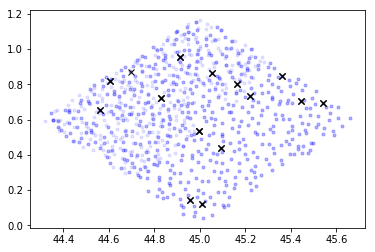

In [29]:
fm = specobj.fibermap   #- shorthand
plt.plot(fm["RA_TARGET"],fm["DEC_TARGET"],'b.', alpha=0.1)
plt.plot(fm["RA_TARGET"][stds],fm["DEC_TARGET"][stds],'kx')

Recall that there can be (will be!) more than one spectrum per object

In [30]:
num_standard_stars = len(set(specobj.fibermap['TARGETID'][stds]))
num_stdstar_exposures = np.count_nonzero(stds)
print('{} exposures of {} standards'.format(num_stdstar_exposures, num_standard_stars))

46 exposures of 15 standards


Let's take a look at the spectra of these standard stars, plotting just the first spectrum from each camera for the first 9 standards.

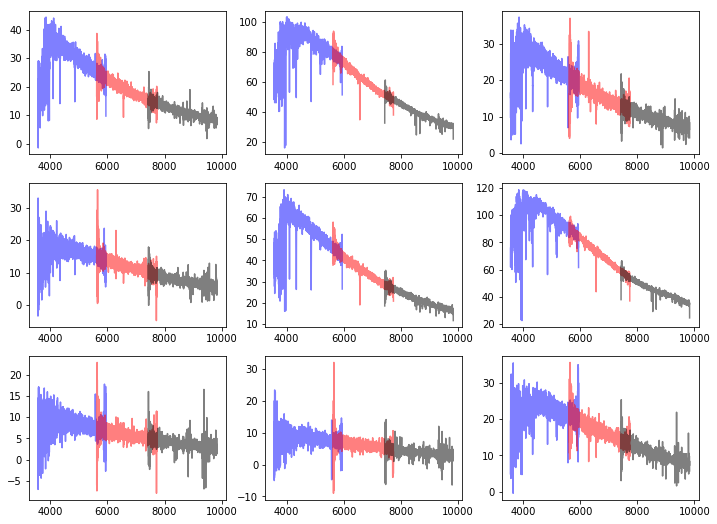

In [32]:
targetids = list(set(specobj.fibermap['TARGETID'][stds]))
figure(figsize=(12,9))
for i, tx in enumerate(targetids[0:9]):
    subplot(3,3,i+1)
    sp = specobj.select(targets=[tx,])
    plt.plot(sp.wave['b'], sp.flux['b'][0], 'b-', alpha=0.5)
    plt.plot(sp.wave['r'], sp.flux['r'][0], 'r-', alpha=0.5)
    plt.plot(sp.wave['z'], sp.flux['z'][0], 'k-', alpha=0.5)
    # plt.show()

These seem realistic. Let's zoom in on some of the Balmer series for the zeroth standard:

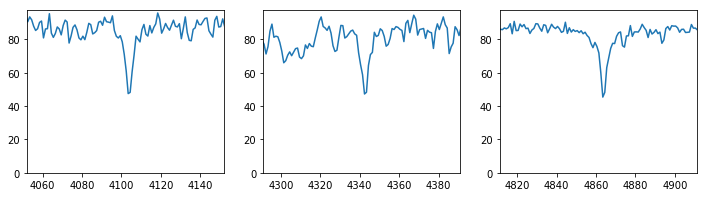

In [33]:
Balmer = [4102,4341,4861]
halfwindow = 50
figure(figsize=(4*len(Balmer), 3))
for i in range(len(Balmer)):
    subplot(1,len(Balmer),i+1)
    plt.axis([Balmer[i]-halfwindow,Balmer[i]+halfwindow,0,np.max(bflux[stds[0]])])
    plt.plot(bwave,bflux[stds[0]])
    # plt.show()

## Redshifts

The directory from which we took these spectra also contains information on the best-fit redshifts for the spectra from the [redrock](https://github.com/desihub/redrock) code. The first pixel we looked at didn't have very many targets, so we'll pick one with more targets for studying the redshifts.

In [34]:
zfilename = specfilename.replace('spectra-64-', 'zbest-64-')
zs = fitsio.read(zfilename)
zs.dtype.descr

[('CHI2', '>f8'),
 ('COEFF', '>f8', (10,)),
 ('Z', '>f8'),
 ('ZERR', '>f8'),
 ('ZWARN', '>i8'),
 ('SPECTYPE', '|S6'),
 ('SUBTYPE', '|S1'),
 ('TARGETID', '>i8'),
 ('DELTACHI2', '>f8'),
 ('BRICKNAME', '|S8')]

Note that due to repeated observations, there could be a different number of spectra than final redshifts, meaning that there isn't a row-by-row mapping between spectra and redshifts...

In [35]:
print(zs.shape[0], 'redshifts')
print(specobj.num_targets(), 'targets')
print(specobj.num_spectra(), 'spectra')
print(specobj.flux['b'].shape, 'shape of flux["b"]')

794 redshifts
794 targets
1819 spectra
(1819, 2380) shape of flux["b"]


...but the `TARGETID` (which *is* intended to be unique) is in this file, too, allowing sources to be uniquely mapped from targeting, to spectra, to redshift. Let's extract all sources that were targeted as quasars using the fibermap information from the spectral file, and plot the first 20:

372 QSOs


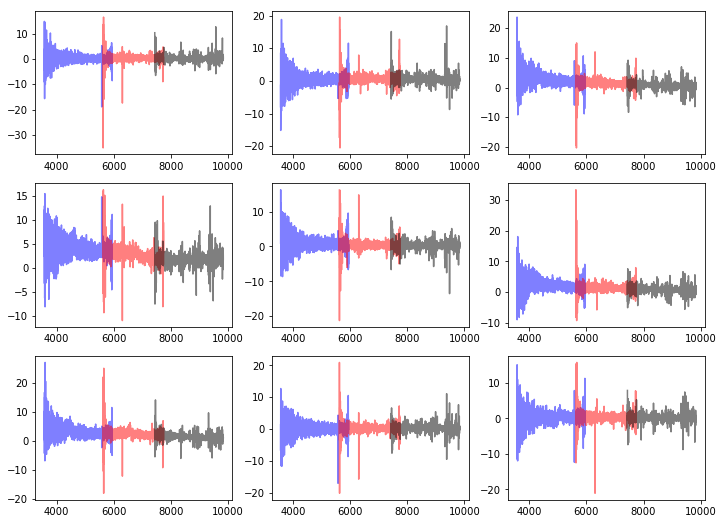

In [36]:
qsos = np.where(specobj.fibermap["DESI_TARGET"] & desi_mask["QSO"])[0]
print(len(qsos), 'QSOs')
plt.figure(figsize=(12,9))
for i in range(len(qsos))[0:9]:
    plt.subplot(3,3,i+1)
    plt.plot(bwave,bflux[qsos[i]],'b', alpha=0.5)
    plt.plot(rwave,rflux[qsos[i]],'r', alpha=0.5)
    plt.plot(zwave,zflux[qsos[i]],'k', alpha=0.5)
    # plt.show()

Let's match these quasar targets to the redshift file on `TARGETID` to extract their best-fit redshifts from `redrock`:

In [37]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zqsos = [index for item in fm[qsos]["TARGETID"] for index in dd[item] if item in dd]

That might be hard to follow at first glance, but all I did was use some "standard" python syntax to match the indices in `zs` (the ordering of objects in the `redrock` redshift file) to those for quasars in `fm` (the ordering of quasars in the fibermap file), on the unique `TARGETID`, such that the indices stored in `qsos` for `fm` point to the corresponding indices in `zqsos` for `zs`. This might help illustrate the result:

In [38]:
zs[zqsos]["TARGETID"][0:7], fm[qsos]["TARGETID"][0:7]

(array([288230376151717091, 288230376151715280, 288230376151717078,
        288230376151717070, 288230376151717090, 288230376151717080,
        288230376151717079]), <Column name='TARGETID' dtype='int64' length=7>
 288230376151717091
 288230376151715280
 288230376151717078
 288230376151717070
 288230376151717090
 288230376151717080
 288230376151717079)

Let's see what best-fit template `redrock` assigned to each quasar. This information is stored in the `SPECTYPE` column.

In [39]:
zs[zqsos]["SPECTYPE"]

array([b'QSO', b'GALAXY', b'QSO', b'QSO', b'QSO', b'QSO', b'QSO',
       b'GALAXY', b'QSO', b'QSO', b'QSO', b'QSO', b'QSO', b'QSO',
       b'GALAXY', b'QSO', b'QSO', b'GALAXY', b'GALAXY', b'QSO', b'GALAXY',
       b'QSO', b'GALAXY', b'QSO', b'QSO', b'QSO', b'QSO', b'GALAXY',
       b'QSO', b'QSO', b'GALAXY', b'QSO', b'GALAXY', b'GALAXY', b'GALAXY',
       b'QSO', b'QSO', b'GALAXY', b'QSO', b'QSO', b'QSO', b'QSO',
       b'GALAXY', b'QSO', b'QSO', b'QSO', b'QSO', b'QSO', b'QSO',
       b'GALAXY', b'QSO', b'QSO', b'QSO', b'GALAXY', b'QSO', b'QSO',
       b'GALAXY', b'QSO', b'GALAXY', b'QSO', b'QSO', b'GALAXY', b'QSO',
       b'QSO', b'QSO', b'QSO', b'QSO', b'QSO', b'QSO', b'GALAXY', b'QSO',
       b'QSO', b'QSO', b'GALAXY', b'QSO', b'QSO', b'QSO', b'GALAXY',
       b'QSO', b'QSO', b'QSO', b'QSO', b'QSO', b'QSO', b'QSO', b'GALAXY',
       b'QSO', b'QSO', b'QSO', b'GALAXY', b'QSO', b'QSO', b'GALAXY',
       b'QSO', b'QSO', b'GALAXY', b'GALAXY', b'QSO', b'QSO', b'QSO',
       b'QSO', b'QSO'

This highlights that redrock isn't doing a fantastic job of fitting quasars.  It correctly identified some, though. And, of course, not everything *targeted* as a quasar will turn out to actually *be* a quasar (there are some contaminants), and in some cases redrock gets the redshift correct but still calls it a galaxy.  Work in progress...

If we'd instead performed this same check for the standard stars, everything would have looked more reasonable:

In [40]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zstds = [index for item in fm[stds]["TARGETID"] for index in dd[item] if item in dd]

For stars, we can also display the type of star that `redrock` fit (this is stored in the `SUBTYPE` column):

In [41]:
zipper = zip(zs[zstds]["SUBTYPE"],zs[zstds]["SPECTYPE"])
for sub, spec in zipper:
    print("{}-{}".format(sub.decode('utf-8'),spec.decode('utf-8')))

G-STAR
G-STAR
F-STAR
G-STAR
F-STAR
F-STAR
F-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
F-STAR
G-STAR
F-STAR
G-STAR
F-STAR
F-STAR
F-STAR
F-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
F-STAR
G-STAR
F-STAR
G-STAR
F-STAR
F-STAR
F-STAR
F-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
F-STAR
G-STAR
F-STAR
G-STAR
F-STAR


(here the conversion to `utf-8` is simply for display purposes because the strings in `SUBTYPE` and `SPECTYPE` are stored as bytes instead of unicode).

OK, back to our quasars. Let's plot the quasar targets that *are identified as quasars* , but add a label for the `SPECTYPE` and the redshift fit by `redrock`. I'll also add some median filtering and over-plot some (approximate) typical quasar emission lines at the redrock redshift (if those lines would fall in the DESI wavelength coverage):

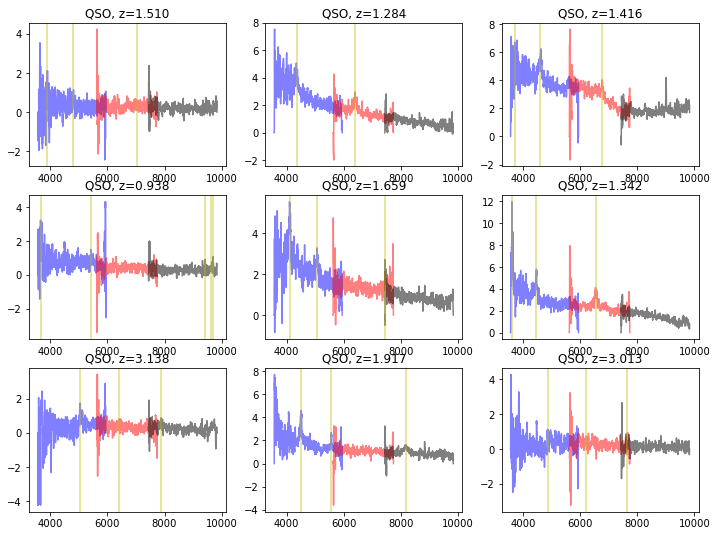

In [42]:
from scipy.signal import medfilt

qsoid = np.where(zs[zqsos]["SPECTYPE"] == b'QSO')[0]
qsolines = np.array([1216,1546,1906,2800,4853,4960,5008])

wave = specobj.wave
flux = specobj.flux

plt.figure(figsize=(12,9))
for i in range(len(qsoid))[0:9]:
    plt.subplot(3,3,1+i)
    spectype = zs[zqsos[qsoid[i]]]["SPECTYPE"].decode('utf-8')
    z = zs[zqsos[qsoid[i]]]["Z"]
    plt.plot(wave['b'], medfilt(flux['b'][qsos[qsoid[i]]], 15), 'b', alpha=0.5)
    plt.plot(wave['r'], medfilt(flux['r'][qsos[qsoid[i]]], 15), 'r', alpha=0.5)
    plt.plot(wave['z'], medfilt(flux['z'][qsos[qsoid[i]]], 15), 'k', alpha=0.5)
    plt.title("{}, z={:.3f}".format(spectype,z))
    for line in qsolines:
        if ((1+z)*line > np.min(bwave)) & ((1+z)*line < np.max(zwave)):
            axvline((1+z)*line, color='y', alpha=0.5)

## Appendix: code versions used

In [43]:
from desitutorials import print_code_versions as pcv
print("This tutorial last ran successfully to completion using the following versions of the following modules:") 
pcv()

This tutorial last ran successfully to completion using the following versions of the following modules:
python      : 3.5.3
numpy       : 1.11.3
scipy       : 0.19.0
astropy     : 1.3.3
yaml        : 3.12
matplotlib  : 2.0.2
fitsio      : 0.9.11
healpy      : 1.10.3
desiutil    : 1.9.7
desispec    : 0.16.0
desitarget  : 0.15.0
speclite    : 0.5


## Appendix: Healpix overview

DESI uses healpix for grouping spectra on the sky.  It is somewhat overkill for our needs, but it has a nice nested pixel structure and has good fast libraries for common operations like determining which pixels cover which points on the sky.

If you aren't familiar with HEALPix, it is an equal-area splitting of the sphere, where the sphere is initially divided into 12 equal-area pixels, and then each of those pixels is divided into 4 new equal-area pixels as `nside` increases (a quad tree). Schematically, here's how `nside` corresponds to pixel *area* in degrees:

In [44]:
sphere_area = 4*180.*180./np.pi
for i in range(10):
    nside = 2**i
    npix = 12*nside**2
    hpx_area = sphere_area / npix
    print(nside, npix, hpx_area)

1 12 3437.746770784939
2 48 859.4366926962348
4 192 214.8591731740587
8 768 53.714793293514674
16 3072 13.428698323378669
32 12288 3.357174580844667
64 49152 0.8392936452111668
128 196608 0.2098234113027917
256 786432 0.052455852825697924
512 3145728 0.013113963206424481


The `nside` at which the example spectra are grouped therefore corresponds to ~0.84 sq. deg. Note that I could have checked this more easily (but less pedagogically) using the useful python [HEALPix](https://healpy.readthedocs.io/en/latest/) library:

In [45]:
hp.nside2pixarea(64,degrees=True)

0.83929364521116678

The spectra are stored in this fashion so that they are grouped (roughly) contiguously on the sky, with a reasonable number of spectra in each directory. It's easy to derive the approximate RA/Dec near each pixel number (note that we sneakily stored the pixel numbers as `pixnums` when we were examining the directory structure):

In [46]:
ras, decs = hp.pix2ang(64, pixnums, nest=True, lonlat=True)

Note that **the DESI Data Model will always use the _NESTED_ scheme for HEALPix**.

In [47]:
zipper = list(zip(pixnums,ras,decs))
for pix,ra,dec in zipper[0:10]:
    print("Pixel(nside=64): {} RA: {} DEC: {}".format(pix,ra,dec))
if len(zipper) > 10:
    print('...')

Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
Pixel(nside=64): 0 RA: 45.0 DEC: 0.5968418305070173
...
